SfM models comparison. Two model - SuperGLUE+SuperPoint, LoFTR - were compared.

In [ ]:
%load_ext autoreload
%autoreload 2

# Progress bars tqdm
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars


from pathlib import Path


from hloc import extract_features, match_features, match_dense, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup

In [2]:
# Data
images = Path('datasets/sacre_coeur')


outputs = Path('outputs/')
outputs_ss = outputs / 'SuperPoint_GLUE'
outputs_loftr = outputs / 'LoFTR'

!rm -rf $outputs
!rm -rf $outputs_ss
!rm -rf $outputs_loftr


# Image pairs
sfm_pairs = outputs / 'pairs-sfm.txt'


# Structure from Motion 
sfm_dir_ss = outputs_ss / 'sfm'
sfm_dir_loftr = outputs_loftr / 'sfm'


# Features
superPoint_features = outputs_ss / 'features.h5'
features_loftr = outputs_loftr / 'features.h5'

# Matches
superGLUE_matches = outputs_ss / 'matches.h5'
matches_loftr = outputs_loftr / 'matches.h5'


# Configs
# SuperPoint + SuperGLUE
superPoint_conf = extract_features.confs['superpoint_aachen']
superGLUE_conf = match_features.confs['superglue']

# LoFTR:
LoFTR_conf = match_dense.confs['loftr']

# SfM

Images

10 mapping images


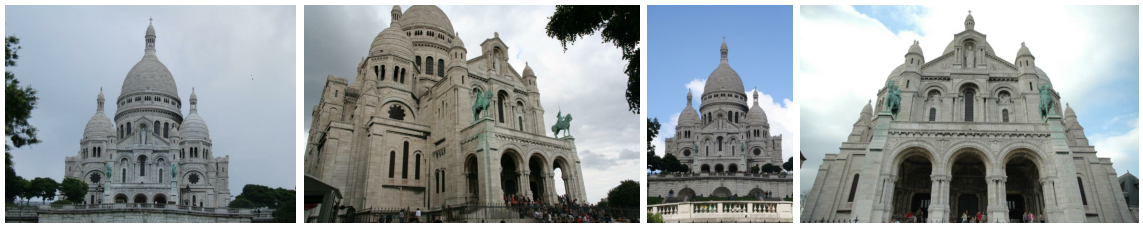

In [3]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]

print(f"Mapping images{len(references)}")
plot_images([read_image(images / r) for r in references[:4]], dpi=50)

Pairs

In [4]:
# outputs/pairs-sfm.txt
!mkdir $outputs
pairs_from_exhaustive.main(sfm_pairs, image_list=references)

[2022/12/05 21:54:24 hloc INFO] Found 45 pairs.


## SuperPoint + SuperGLUE

Featuring

In [5]:
# outputs/SuperPoint_GLUE/features.h5
extract_features.main(superPoint_conf, images, image_list=references, feature_path=superPoint_features)

[2022/12/05 21:54:32 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/10 [00:00<?, ?it/s]

[2022/12/05 21:55:18 hloc INFO] Finished exporting features.


PosixPath('outputs/SuperPoint_GLUE/features.h5')

Matching

In [ ]:
# outputs/demo/pairs-sfm.txt
match_features.main(superGLUE_conf, sfm_pairs, features=superPoint_features, matches=superGLUE_matches);

Reconstruction

In [7]:
model = reconstruction.main(sfm_dir_ss, images, sfm_pairs, superPoint_features, superGLUE_matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

[2022/12/05 22:06:47 hloc INFO] Creating an empty database...
[2022/12/05 22:06:47 hloc INFO] Importing images into the database...
[2022/12/05 22:06:47 hloc INFO] Importing features into the database...


  0%|          | 0/10 [00:00<?, ?it/s]

[2022/12/05 22:06:47 hloc INFO] Importing matches into the database...


  0%|          | 0/45 [00:00<?, ?it/s]

[2022/12/05 22:06:47 hloc INFO] Performing geometric verification of the matches...
[2022/12/05 22:06:58 hloc INFO] Running 3D reconstruction...
[2022/12/05 22:07:09 hloc INFO] Reconstructed 1 model(s).
[2022/12/05 22:07:09 hloc INFO] Largest model is #0 with 10 images.
[2022/12/05 22:07:09 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 1925
	num_observations = 8246
	mean_track_length = 4.28364
	mean_observations_per_image = 824.6
	mean_reprojection_error = 1.00284
	num_input_images = 10


## LoFTR

In [11]:
!mkdir $outputs_loftr
features, matches = match_dense.main(LoFTR_conf, sfm_pairs, images, matches=matches_loftr, features=features_loftr)

[2022/12/05 22:11:30 hloc INFO] Extracting semi-dense features with configuration:
{'cell_size': 1,
 'max_error': 1,
 'model': {'name': 'loftr', 'weights': 'outdoor'},
 'output': 'matches-loftr',
 'preprocessing': {'dfactor': 8, 'grayscale': True, 'resize_max': 1024}}
/home/nadir/anaconda3/envs/StudProject/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning:

This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

[2022/12/05 22:11:32 hloc INFO] Performing dense matching...


  0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
model = reconstruction.main(sfm_dir_loftr, images, sfm_pairs, features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()